# Laboratory of Computational Physics mod.B

## Fifth assignment

### Group name: LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

The aim of this notebook is to implement some techniques concerning the Restricted Boltzmann Machines (RBM) in some corrupted data sequences. We will compare an econding of them via bit or spin levels.

In [38]:
#import packages
import numpy as np
import pandas as pd

from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from IPython.display import Latex

In [61]:
#this cell contains some user defined function useful later on

def create_coord(np, x0):
    '''
    
    normalize in a box all the visible and hidden units
    
    '''
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5 
        
    return (x,y)

def mycolor(val):
    '''
    
    define a custom color for lines and dots
    
    '''
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(M, epoch=0):
    '''
    
    plot the boltzmann layers and weights
    
    '''
    A = 2. / w.max()
    (x1, y1) = create_coord(L,0)
    (x2, y2) = create_coord(M,1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i,j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i,j]))
    A = 300./(a.max()+b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*np.abs(a[i]), zorder=2, c=mycolor(a[i]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*np.abs(b[j]), zorder=2, c=mycolor(b[j]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    plt.show()
    
def activate(v_in, wei, bias, DE, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + np.exp(-DE*act))
    n = len(act)
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('out=', v_out)
        
    return(v_out)

def mountain_plot(betas, z):
    '''
    
    plots the moutain-shaped graph with the accuracy for a mesh of betas
    

    '''
    x, y = np.meshgrid(betas, betas)

    fig = plt.figure()
    ax = Axes3D(fig)

    #plot the surface.
    surf = ax.plot_surface(x,y, z, vmin=30.,vmax=90., cmap='gist_earth')

    #add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('$\\beta$, positive phase')
    ax.set_ylabel('$\\beta$, negative phase')
    ax.set_zlabel('accuracy')
    ax.view_init(30,200)

    plt.show()
    
def mean_square_increment(dw):
    '''
    
    calculate the means squared increment given the weights
    
    '''
    total = 0
    for i in range(L):
        for j in range(M):
            total += dw[i,j]**2
    total /= L*M
    
    return total

def evaluate_beta(beta_p, beta_n, v0, v_uncurrupted, a, b, w):
    '''
    
    given the sequences before and after RBM, this function trains the RBM and
    compute the comparison with the uncurrupted data for different beta
    
    
    '''
    v2 = np.full((N, L), vmin)
    for n in range(N):
        h = activate(v0[n], w,b,GAP*beta_p)
        v2[n] = activate(h, w.T,a,GAP*beta_n)
    
    vdiff = np.sum(np.abs(v_uncurrupted-v2), axis=1)
    tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
    perc = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100
    
    return tot, perc 


def training_RBM(M,w,a,b,info=True):

    #minibatches
    mini, m = 500, 0 
    #epochs
    nepoch = 50
    #l_rate
    l_rate = 1.
    #dw
    weights_spin = np.zeros(nepoch)

    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m==0:
                #initialize
                v_data, v_model = np.zeros(L), np.zeros(L) 
                h_data, h_model = np.zeros(M), np.zeros(M) 
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

            #positive CD phase
            h = activate(v[n],w,b,GAP)
            #negative CD phase
            vf = activate(h, w.T,a,GAP)
            #positive CD nr 2
            hf = activate(vf,w,b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            if m==mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C * (h_data - h_model)
                weights_spin[epoch-1] = mean_square_increment(dw)

                w += dw
                a += da
                b += db
                m = 0

        #randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)
        
        if info:
            if (epoch % 50 == 0):
                plotgraph(M,epoch)
                print(' l_rate=', l_rate)
                
    return w,a,b

## 1) Differences in $\beta$

We start by encoding the data in the 'spins' format, namely with +1 and -1 in the sequences. The aim of this first section is to see what happens if we change the temperature ($\beta$ parameter in the sigmoid function) in our RBM model.

In [40]:
#we load the sequences generated with the file coded at lesson

#corruption probability
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


In [41]:
M=3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

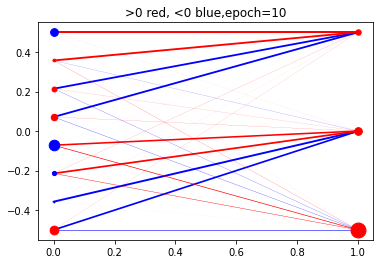

 l_rate= 0.6666666666666663


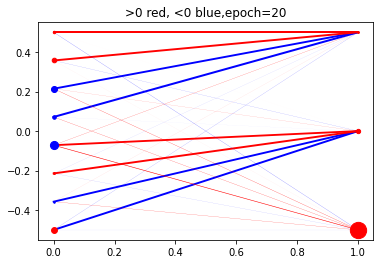

 l_rate= 0.5


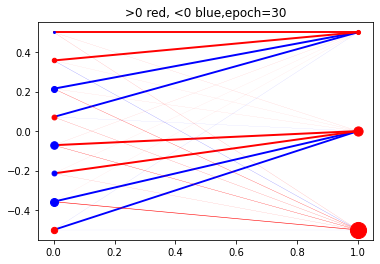

 l_rate= 0.4000000000000001


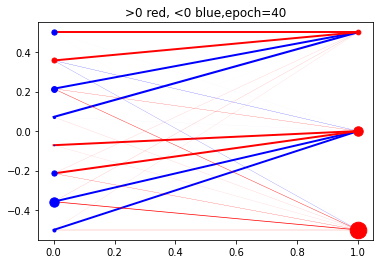

 l_rate= 0.3333333333333335


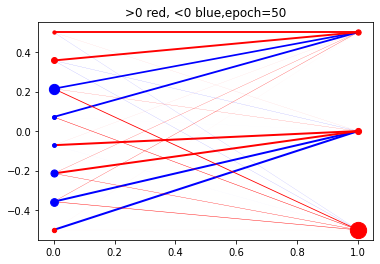

 l_rate= 0.28571428571428586


In [42]:
#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_spin = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_spin[epoch-1] = mean_square_increment(dw)
            w += dw
            a += da
            b += db
            m = 0
            
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 10 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

## 2) corrupted/non-corrupted comparison

The answer to point one has not been given yet. That's why we need also point two of the exercise, where we define an accuracy function, and we see how different values of temperature influence the denoising performance of the Boltzmann Machine.


In [43]:
#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

<ipython-input-39-b5218e333d59>:74: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


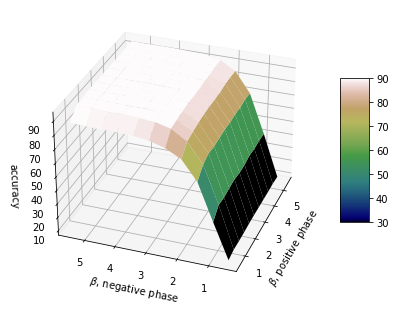

In [44]:
mountain_plot(betas, percs)

In [60]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print("====================================")
print("Accuracy before denoising: ", acc_bf_denois, "%")
print("Accuracy after denoising:  ", acc_at_denois, "%")
print("====================================")

Accuracy before denoising:  43.01 %
Accuracy after denoising:   79.57 %


In order to understand whether the correction is working, we compare the accuracy, intended as the percentage of strings identical to the corresponding one in the uncorrupted dataframe, before and after the denoising with the Boltzmann Machine.

**Before** the denoising, the accuracy is equal to 43.2\% $\sim0.9^8\times 100\sim43\%$, that is the theoretical probability to obtain two equal strings if the bit-flip probability is $0.1$.

**After** the denoising we reach an accuracy of about 94\%, almost doubling the one before denoising.
We can then conlcude that the correction has been working succesfully.

## 3a) Introducing a fifth state

We now see what happens if we add (with equal probability wrt others) a fifth state of the kind '**11111111**'. We add a small corruption $q=0.1$.

In [46]:
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'_seq4.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

[1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1]
[0 0 1 1 1 0 0 1]
[1 0 1 1 1 1 0 0]
[1 0 1 1 1 1 1 1]
[1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1]
[0 0 1 1 1 0 0 0]
[1 1 0 0 1 1 0 0]


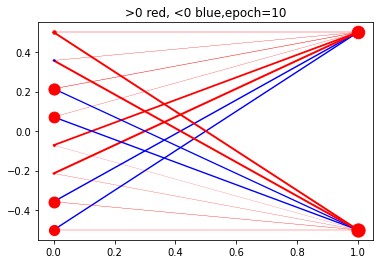

 l_rate= 0.6666666666666663


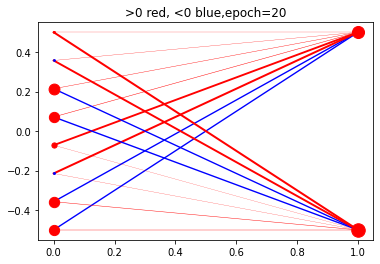

 l_rate= 0.5


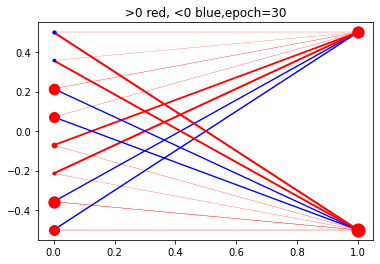

 l_rate= 0.4000000000000001


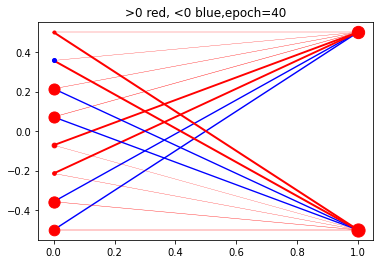

 l_rate= 0.3333333333333335


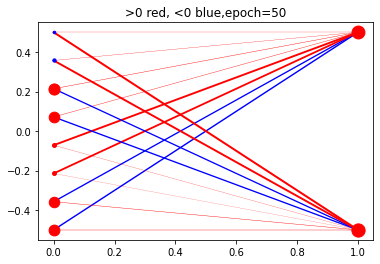

 l_rate= 0.28571428571428586


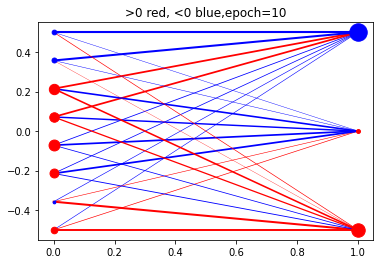

 l_rate= 0.6666666666666663


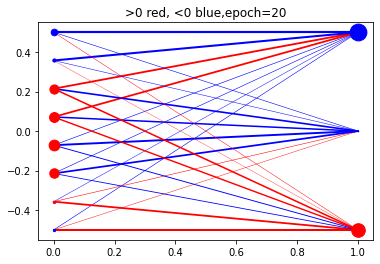

 l_rate= 0.5


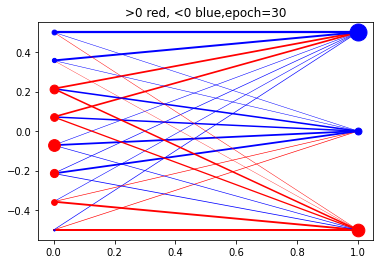

 l_rate= 0.4000000000000001


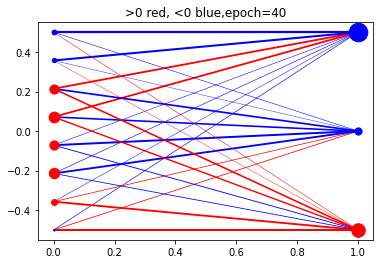

 l_rate= 0.3333333333333335


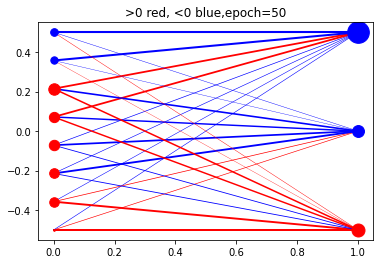

 l_rate= 0.28571428571428586


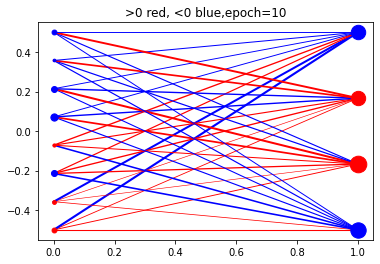

 l_rate= 0.6666666666666663


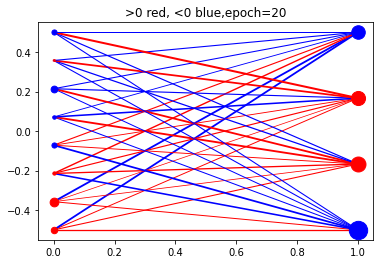

 l_rate= 0.5


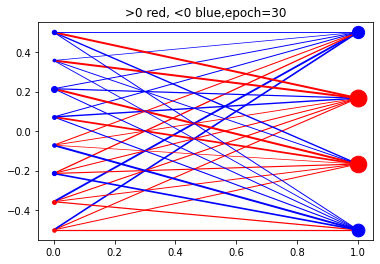

 l_rate= 0.4000000000000001


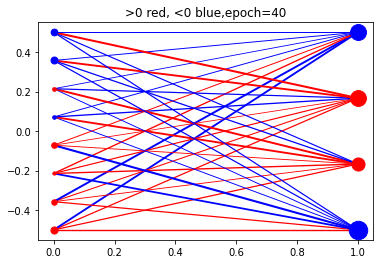

 l_rate= 0.3333333333333335


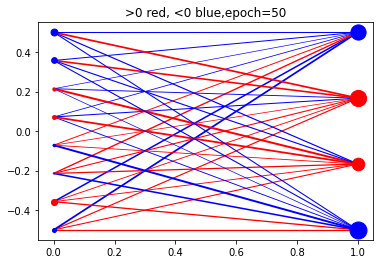

 l_rate= 0.28571428571428586


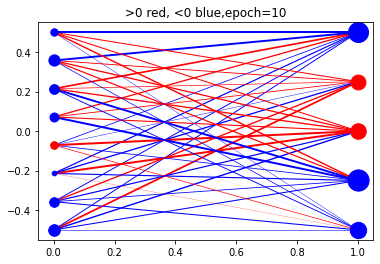

 l_rate= 0.6666666666666663


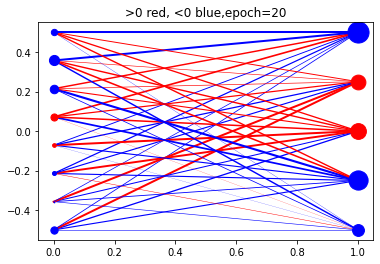

 l_rate= 0.5


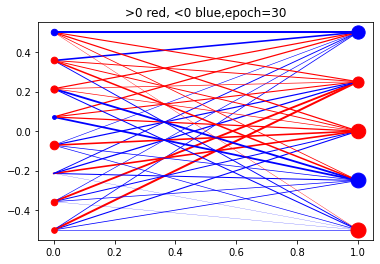

 l_rate= 0.4000000000000001


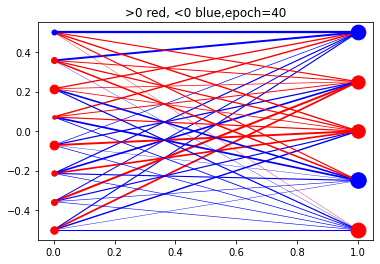

 l_rate= 0.3333333333333335


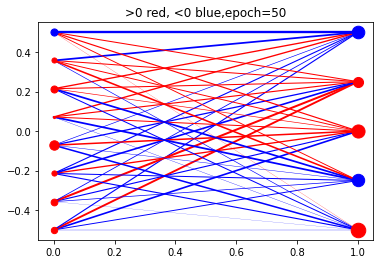

 l_rate= 0.28571428571428586


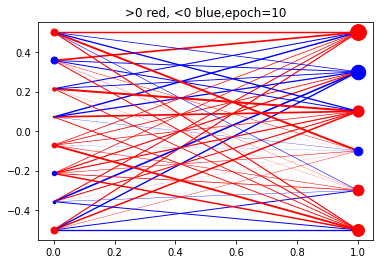

 l_rate= 0.6666666666666663


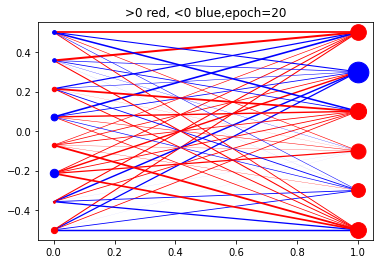

 l_rate= 0.5


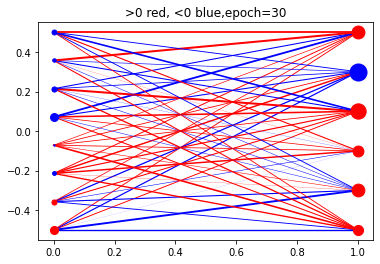

 l_rate= 0.4000000000000001


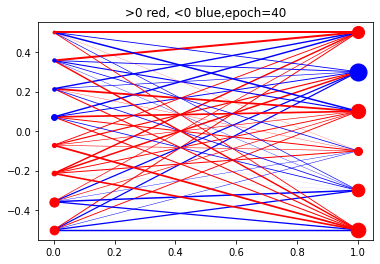

 l_rate= 0.3333333333333335


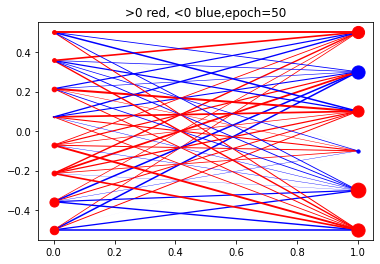

 l_rate= 0.28571428571428586


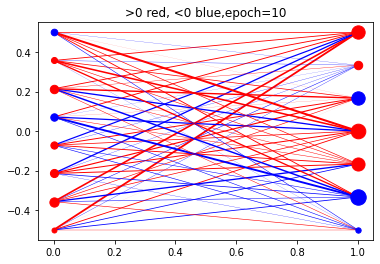

 l_rate= 0.6666666666666663


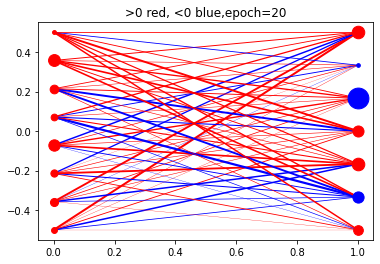

 l_rate= 0.5


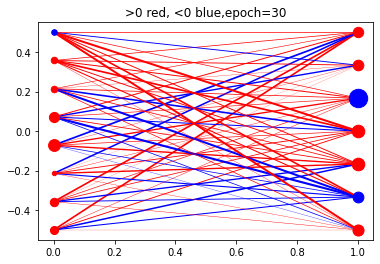

 l_rate= 0.4000000000000001


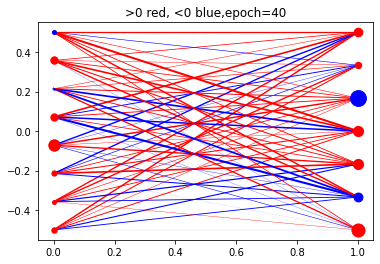

 l_rate= 0.3333333333333335


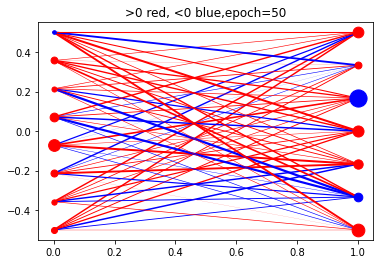

 l_rate= 0.28571428571428586


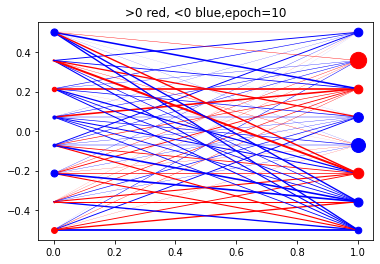

 l_rate= 0.6666666666666663


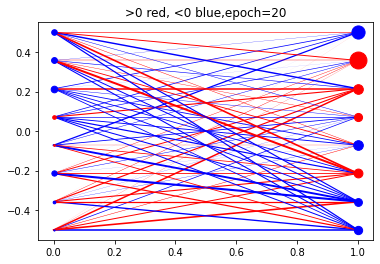

 l_rate= 0.5


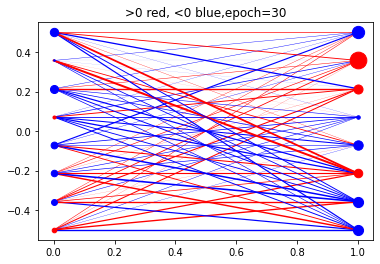

 l_rate= 0.4000000000000001


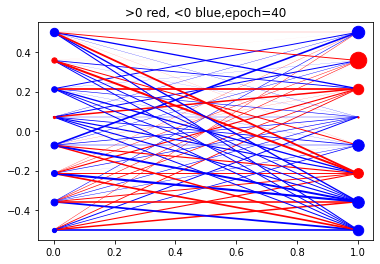

 l_rate= 0.3333333333333335


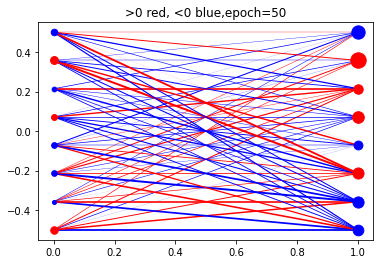

 l_rate= 0.28571428571428586


In [47]:
M_list = [2,3,4,5,6,7,8]
W_list = []
a_list = []
b_list = []

#we construct here our RBM initializing randomly the weights
    
    #number of hidden units
for M in M_list:
    sigma = np.sqrt(4. / float(N+M))
    w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)

    w_t, a_t, b_t = training_RBM(M,w,a,b)
    
    W_list.append(w_t)
    a_list.append(a_t)
    b_list.append(b_t)

In [48]:
#probability (null) of corruption for perfectly-generated data
q1 = 0
n_betas = 7

betas = np.linspace(0.5, 7.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq4.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1
    
tots, percs = np.zeros((len(M_list), n_betas)), np.zeros((len(M_list), n_betas))

for i in range(len(M_list)):
    for j in range(n_betas):
        tot, perc = evaluate_beta(1., betas[j], v0, v_uncurrupted, a_list[i], b_list[i], W_list[i])
        tots[i,j] = tot
        percs[i, j] = perc 

[[ 4.96 40.63 56.04 61.51 64.13 66.22 68.  ]
 [10.03 64.68 76.95 78.   78.2  77.49 78.07]
 [10.09 67.83 77.03 77.68 77.57 76.97 77.06]
 [11.35 66.58 76.51 77.7  78.98 79.28 79.57]
 [11.17 64.37 74.93 77.6  77.74 78.93 78.99]
 [12.18 63.52 73.11 75.42 76.32 76.84 77.36]
 [12.24 64.56 74.05 76.25 76.46 77.4  76.92]]


<ipython-input-49-ee808b0671ca>:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


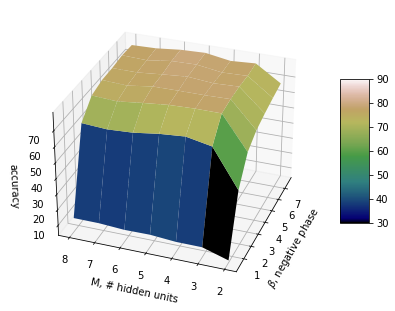

In [49]:
print(percs)
x, y = np.meshgrid(betas, M_list)

fig = plt.figure()
ax = Axes3D(fig)

#plot the surface.
surf = ax.plot_surface(x,y, percs, vmin=30.,vmax=90., cmap='gist_earth')

#add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_ylabel('M, # hidden units')
ax.set_xlabel('$\\beta$, negative phase')
ax.set_zlabel('accuracy')
ax.view_init(30,200)

plt.show()   

In [59]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print("====================================")
print("Accuracy before denoising: ", acc_bf_denois, "%")
print("Accuracy after denoising:  ", acc_at_denois, "%")
print("====================================")

Accuracy before denoising:  43.01 %
Accuracy after denoising:   79.57 %


With respect to the case with only 4 sequences the optimal Boltzmann machine performs slightly worse. This could be due also to the fact that the structure of the fifth state needs a global vision to be identified, at difference with what happens with the other four sequences.

## 3b) Introducing a sixth state

We now see what happens if we add (with equal probability wrt others) a sixth state of the kind '**10101000**'. We add a small corruption $q=0.1$.

In [62]:
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'_seq45.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

each of N=10000data samples has L=8 digits
[1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1]
[1 0 1 0 1 0 0 1]
[0 1 1 0 0 1 1 1]
[1 0 1 1 0 0 1 1]
[1 1 1 1 1 1 1 1]
[0 0 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[1 0 1 1 1 1 0 0]
[1 0 0 1 0 0 1 1]


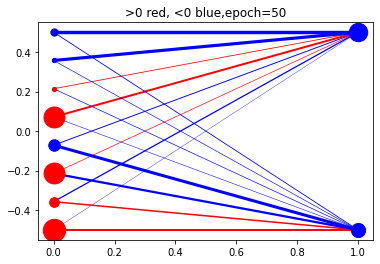

 l_rate= 0.28571428571428586


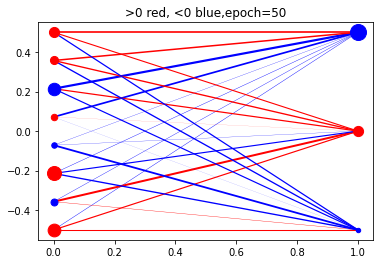

 l_rate= 0.28571428571428586


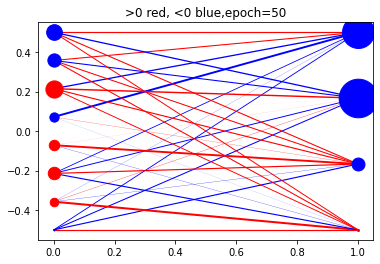

 l_rate= 0.28571428571428586


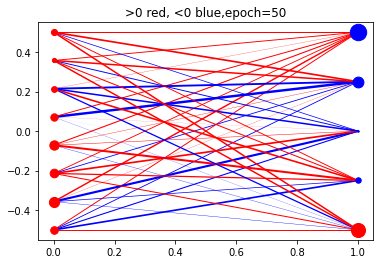

 l_rate= 0.28571428571428586


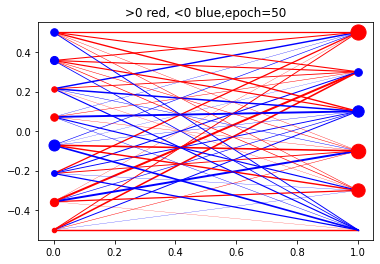

 l_rate= 0.28571428571428586


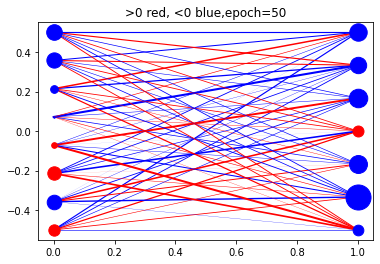

 l_rate= 0.28571428571428586


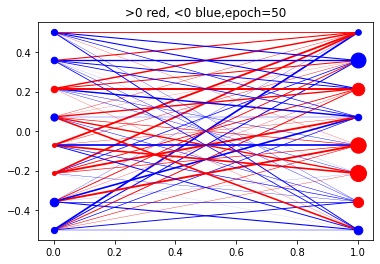

 l_rate= 0.28571428571428586


In [63]:
M_list = [2,3,4,5,6,7,8]
W_list = []
a_list = []
b_list = []

#we construct here our RBM initializing randomly the weights
    
    #number of hidden units
for M in M_list:
    sigma = np.sqrt(4. / float(N+M))

    w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)

    #----------------------------

    #minibatches
    mini, m = 500, 0 
    #epochs
    nepoch = 50
    #l_rate
    l_rate = 1.
    #dw
    weights_spin = np.zeros(nepoch)

    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m==0:
                #initialize
                v_data, v_model = np.zeros(L), np.zeros(L) 
                h_data, h_model = np.zeros(M), np.zeros(M) 
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

            #positive CD phase
            h = activate(v[n],w,b,GAP)
            #negative CD phase
            vf = activate(h, w.T,a,GAP)
            #positive CD nr 2
            hf = activate(vf,w,b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            if m==mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C * (h_data - h_model)
                weights_spin[epoch-1] = mean_square_increment(dw)

                w += dw
                a += da
                b += db
                m = 0

        #randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)

        if (epoch == nepoch):
            plotgraph(M,epoch)
            print(' l_rate=', l_rate)

            W_list.append(w)
            a_list.append(a)
            b_list.append(b)

In [64]:
#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 5
betas = np.linspace(0.5, 5.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

In [65]:
#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 7
betas = np.linspace(0.5, 7.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

    
tots, percs = np.zeros((len(M_list), n_betas)), np.zeros((len(M_list), n_betas))

for i in range(len(M_list)):
    for j in range(n_betas):
        tot, perc = evaluate_beta(1., betas[j], v0, v_uncurrupted, a_list[i], b_list[i], W_list[i])
        tots[i,j] = tot
        percs[i, j] = perc 

[[ 3.34 20.72 31.58 36.24 38.58 41.09 42.24]
 [ 8.31 57.72 74.91 78.8  79.06 78.95 79.32]
 [10.89 64.67 73.22 73.81 74.29 74.6  74.91]
 [11.5  63.14 72.05 74.49 75.98 76.33 76.37]
 [13.39 62.24 68.74 69.46 69.54 70.31 70.4 ]
 [13.44 60.52 68.02 69.22 69.79 70.05 69.91]
 [13.49 59.86 67.69 70.46 70.79 70.68 71.27]]


<ipython-input-66-ee808b0671ca>:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


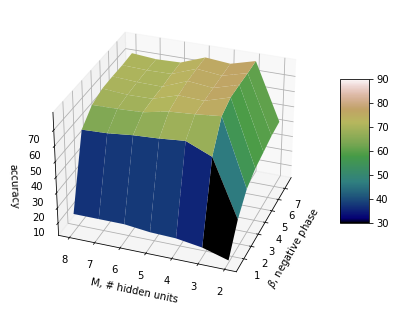

In [66]:
print(percs)
x, y = np.meshgrid(betas, M_list)

fig = plt.figure()
ax = Axes3D(fig)

#plot the surface.
surf = ax.plot_surface(x,y, percs, vmin=30.,vmax=90., cmap='gist_earth')

#add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_ylabel('M, # hidden units')
ax.set_xlabel('$\\beta$, negative phase')
ax.set_zlabel('accuracy')
ax.view_init(30,200)

plt.show()   

In [67]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print("====================================")
print("Accuracy before denoising: ", acc_bf_denois, "%")
print("Accuracy after denoising:  ", acc_at_denois, "%")
print("====================================")

Accuracy before denoising:  43.68 %
Accuracy after denoising:   79.32000000000001 %


## Larger error rate

We now see how the behaviour change when introducing a larger spin-flip probability, i.e. a larger error rate.


[0 1 1 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[1 1 1 0 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 1 0 1 0 0 0]
[1 1 1 0 1 1 0 0]
[1 1 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


<ipython-input-2-b5218e333d59>:74: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


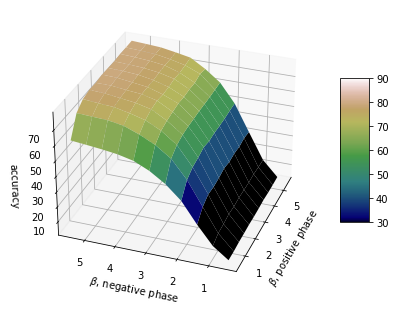

In [22]:
#corruption probability
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)

#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
        
        
mountain_plot(betas, percs)

Since, as expected, we notice a decrease in accuracy, due to how the dataset has been generated, we try to decrease the temperature w.r.t. the lower noise case studied before.
This leads to an increase of the accuracy of about 5$\%$, that displays a plateau at $\sim 80 \%$ accuracy

[0 1 1 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[1 1 1 0 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 1 0 1 0 0 0]
[1 1 1 0 1 1 0 0]
[1 1 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


<ipython-input-2-b5218e333d59>:74: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


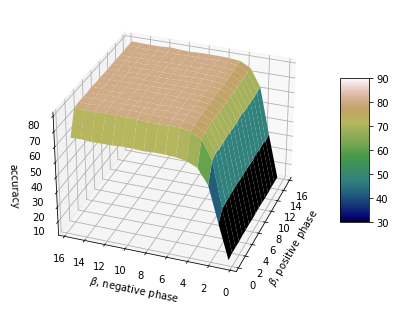

In [23]:
#corruption probability
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)


w,a,b = training_RBM(M,w,a,b, info=False)



#number of different betas and linspace
n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
        
mountain_plot(betas, percs)

#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

In [24]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print(acc_at_denois)

80.85


## Fifth state
qua è da sistemare l'M 

each of N=10000data samples has L=8 digits
[1 1 1 1 0 0 0 0]
[1 1 1 0 1 0 0 1]
[0 0 1 1 1 0 0 0]
[1 0 0 1 0 1 0 0]
[1 0 1 1 0 0 1 0]
[1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1]
[0 0 1 1 1 0 0 0]
[1 1 0 0 1 1 0 0]


<ipython-input-2-b5218e333d59>:74: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


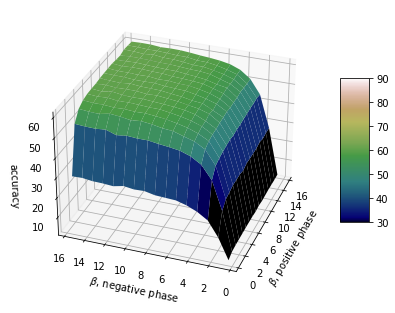

In [25]:
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'_seq4.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 6

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)


#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq4.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
mountain_plot(betas, percs)

In [26]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

## Sixth state

each of N=10000data samples has L=8 digits
[1 1 1 1 0 0 0 0]
[1 1 1 0 1 0 0 1]
[1 0 1 0 1 0 0 1]
[1 1 1 0 0 1 1 0]
[1 0 1 0 1 0 0 1]
[1 1 1 1 1 1 1 1]
[0 1 0 1 1 0 1 1]
[0 0 1 0 1 1 1 0]
[1 0 1 1 1 1 0 0]
[1 0 0 1 0 0 1 1]


<ipython-input-2-b5218e333d59>:74: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


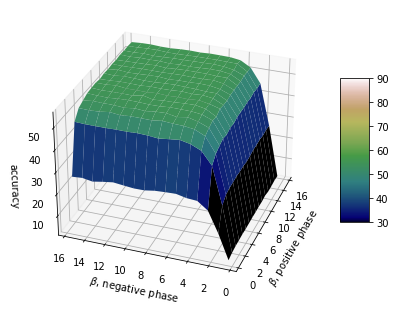

In [27]:
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'_seq45.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 4

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)

#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
mountain_plot(betas, percs)


#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

## 5) Binary encoding

We now change the encoding to the 'bits' format, namely with 0's and 1's in the sequences.

In [28]:
#we load the sequences generated with the file coded at lesson

#corruption probability
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

#changing the encoding
SPINS = False

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

each of N=10000data samples has L=8 digits
[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


In [29]:
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

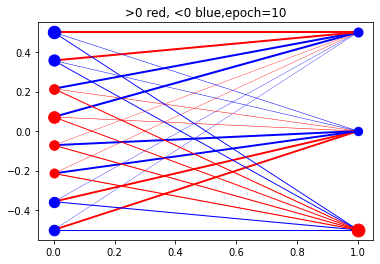

 l_rate= 0.6666666666666663


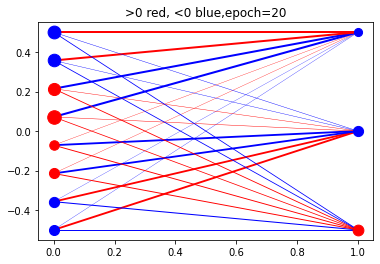

 l_rate= 0.5


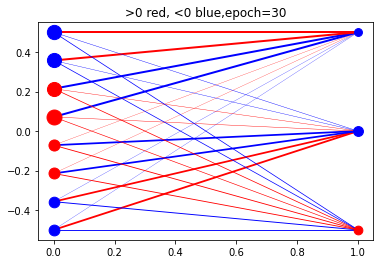

 l_rate= 0.4000000000000001


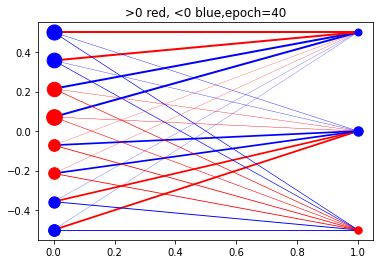

 l_rate= 0.3333333333333335


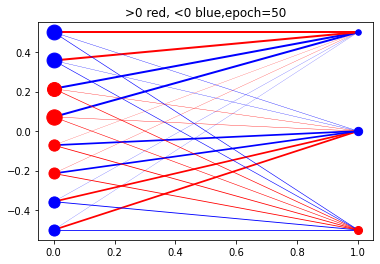

 l_rate= 0.28571428571428586


In [30]:
#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_bit = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_bit[epoch-1] = mean_square_increment(dw)
            w += dw
            a += da
            b += db
            m = 0
            
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 10 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

In [31]:
#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted= np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

<ipython-input-2-513cc20a0244>:74: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


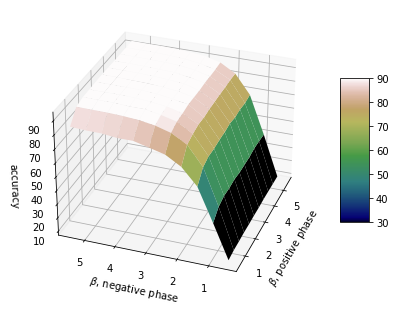

In [32]:
mountain_plot(betas, percs)

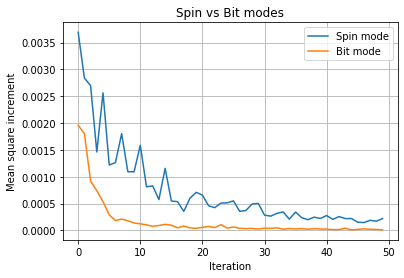

In [33]:
plt.plot(np.arange(nepoch),weights_spin, label = "Spin mode")
plt.plot(np.arange(nepoch),weights_bit, label = "Bit mode")
plt.xlabel('Iteration')
plt.ylabel('Mean square increment')
plt.title('Spin vs Bit modes')
plt.grid()
plt.legend()

plt.show()